In [49]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [50]:
df = pd.read_csv('IMDB Dataset.csv')

In [51]:
df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


### 1. Data Cleaning

In [52]:
df.isnull().sum()

review       0
sentiment    0
dtype: int64

In [53]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     50000 non-null  object
 1   sentiment  50000 non-null  object
dtypes: object(2)
memory usage: 781.4+ KB


In [54]:
df.shape

(50000, 2)

In [55]:
df.size

100000

In [56]:
df.duplicated().sum()

np.int64(418)

In [57]:
df = df.drop_duplicates(keep='first')

In [58]:
df.shape

(49582, 2)

In [59]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()

df['sentiment'] = le.fit_transform(df['sentiment'])

In [60]:
df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,1
1,A wonderful little production. <br /><br />The...,1
2,I thought this was a wonderful way to spend ti...,1
3,Basically there's a family where a little boy ...,0
4,"Petter Mattei's ""Love in the Time of Money"" is...",1


In [61]:
# Text Cleaning
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Error loading stopwords: <urlopen error [Errno 11001]
[nltk_data]     getaddrinfo failed>
[nltk_data] Error loading wordnet: <urlopen error [Errno 11001]
[nltk_data]     getaddrinfo failed>


False

In [62]:
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

In [63]:
def clean_text(text):
    text = text.lower()
    text = re.sub(r'<.*?>', ' ', text)
    text = re.sub(r'[^a-zA-Z ]', ' ', text)
    text = re.sub(r'\s+', ' ', text)

    tokens = text.split()
    tokens = [word for word in tokens if word not in stop_words] 

    tokens = [lemmatizer.lemmatize(word) for word in tokens]

    return " ".join(tokens)

df['cleaned_review'] = df['review'].apply(clean_text)

In [64]:
df.head()

,review,sentiment,cleaned_review
0,One of the other reviewers has mentioned that ...,1,one reviewer mentioned watching oz episode hoo...
1,A wonderful little production. <br /><br />The...,1,wonderful little production filming technique ...
2,I thought this was a wonderful way to spend ti...,1,thought wonderful way spend time hot summer we...
3,Basically there's a family where a little boy ...,0,basically family little boy jake think zombie ...
4,"Petter Mattei's ""Love in the Time of Money"" is...",1,petter mattei love time money visually stunnin...


### 2. EDA

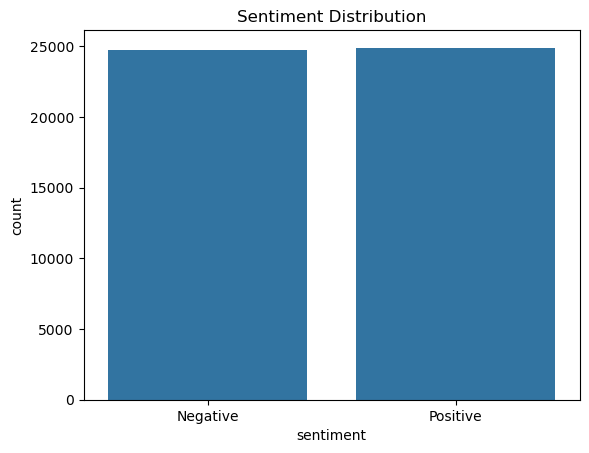

In [65]:
sns.countplot(data=df, x=df['sentiment'])
plt.xticks([0,1], ['Negative', 'Positive'])
plt.title("Sentiment Distribution")
plt.show()

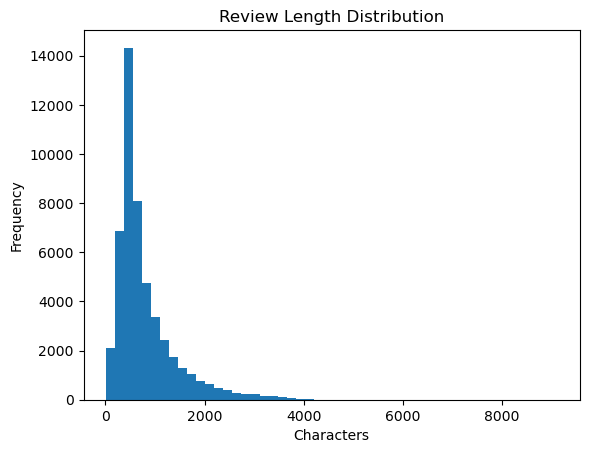

In [66]:
df['review_length'] = df['cleaned_review'].apply(len)

plt.hist(df['review_length'], bins=50)
plt.title("Review Length Distribution")
plt.xlabel("Characters")
plt.ylabel("Frequency")
plt.show()

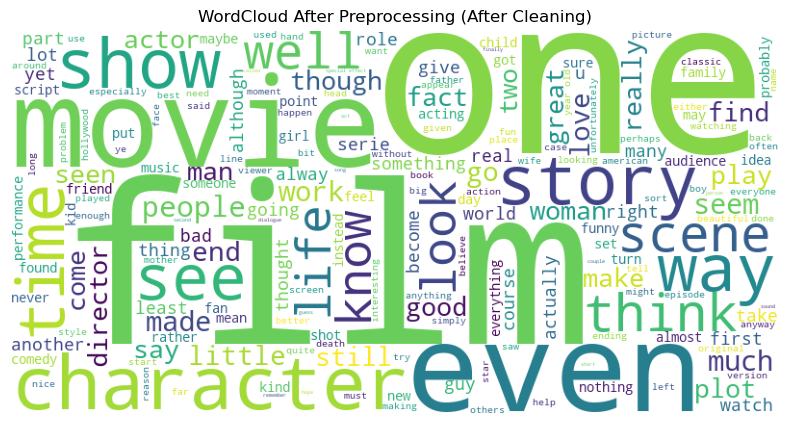

In [67]:
# WORDCLOUD
from wordcloud import WordCloud

clean_wc = WordCloud(
    width=800,
    height=400,
    background_color='white'
).generate(" ".join(df['cleaned_review']))

plt.figure(figsize=(10,5))
plt.imshow(clean_wc)
plt.axis('off')
plt.title("WordCloud After Preprocessing (After Cleaning)")
plt.show()


### TF-IDF VECTORIZATION

In [68]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split

In [69]:
X = df['cleaned_review']
y = df['sentiment']

In [70]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [71]:
# TF-IDF 
tfidf_vectorizer = TfidfVectorizer(
    max_features=5000,     
    ngram_range=(1,2),     
    stop_words='english'
)

In [72]:
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

### 3. Model Building with TF-IDF

In [73]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, classification_report

In [74]:
# MULTINOMIAL MODEL
nb_model = MultinomialNB()
nb_model.fit(X_train_tfidf, y_train)
nb_pred = nb_model.predict(X_test_tfidf)

In [75]:
# LOGISTICREGRESSION MODEL
lr_model = LogisticRegression(max_iter=1000)
lr_model.fit(X_train_tfidf, y_train)
lr_pred = lr_model.predict(X_test_tfidf)

In [76]:
# LINEAR SVC
svm_model = LinearSVC()
svm_model.fit(X_train_tfidf, y_train)
svm_pred = svm_model.predict(X_test_tfidf)

In [77]:
print("=== Multinomial Naive Bayes ===")
print("Accuracy: ", accuracy_score(y_test, nb_pred))
print("Precision: ", precision_score(y_test, nb_pred))
print("Recall: ", recall_score(y_test, nb_pred))
print("Classification Report:\n", classification_report(y_test, nb_pred))

=== Multinomial Naive Bayes ===
Accuracy:  0.8542906120802662
Precision:  0.8422480620155038
Recall:  0.8732167972674302
Classification Report:
               precision    recall  f1-score   support

           0       0.87      0.84      0.85      4940
           1       0.84      0.87      0.86      4977

    accuracy                           0.85      9917
   macro avg       0.85      0.85      0.85      9917
weighted avg       0.85      0.85      0.85      9917



In [78]:
print("=== Logistic Regression ===")
print("Accuracy: ", accuracy_score(y_test, lr_pred))
print("Precision: ", precision_score(y_test, lr_pred))
print("Recall: ", recall_score(y_test, lr_pred))
print("Classification Report:\n", classification_report(y_test, lr_pred))

=== Logistic Regression ===
Accuracy:  0.8847433699707573
Precision:  0.8741217798594848
Recall:  0.8999397227245328
Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.87      0.88      4940
           1       0.87      0.90      0.89      4977

    accuracy                           0.88      9917
   macro avg       0.89      0.88      0.88      9917
weighted avg       0.89      0.88      0.88      9917



In [79]:
print("=== Linear SVC ===")
print("Accuracy: ", accuracy_score(y_test, svm_pred))
print("Precision: ", precision_score(y_test, svm_pred))
print("Recall: ", recall_score(y_test, svm_pred))
print("Classification Report:\n", classification_report(y_test, svm_pred))

=== Linear SVC ===
Accuracy:  0.87949984874458
Precision:  0.8757949125596184
Recall:  0.8854731766124171
Classification Report:
               precision    recall  f1-score   support

           0       0.88      0.87      0.88      4940
           1       0.88      0.89      0.88      4977

    accuracy                           0.88      9917
   macro avg       0.88      0.88      0.88      9917
weighted avg       0.88      0.88      0.88      9917



In [80]:
# At this point i tested three multiple models for my dataset but the best accuracy that model give is Logistic Regression.

### CountVectorization

In [81]:
from sklearn.feature_extraction.text import CountVectorizer

In [82]:
cv_vectorizer = CountVectorizer()

In [83]:
X_train_cv = cv_vectorizer.fit_transform(X_train)
X_test_cv = cv_vectorizer.transform(X_test)

### 3.1 Model Building with CV 

In [84]:
# MULTINOMIAL MODEL
nb_model_cv = MultinomialNB()
nb_model_cv.fit(X_train_cv, y_train)
nb_model_cv_pred = nb_model_cv.predict(X_test_cv)

In [85]:
# LOGISTIC REGRESSION
lr_model_cv = LogisticRegression(max_iter=1000)
lr_model_cv.fit(X_train_cv, y_train)
lr_model_cv_pred = lr_model_cv.predict(X_test_cv)

In [87]:
# LINEAR SVC
svc_model_cv = LinearSVC(max_iter=2000)
svc_model_cv.fit(X_train_cv, y_train)
svc_model_cv_pred = svc_model_cv.predict(X_test_cv)

In [88]:
print("=== Multinomial Naive Bayes ===")
print("Accuracy: ", accuracy_score(y_test, nb_model_cv_pred))
print("Precision: ", precision_score(y_test, nb_model_cv_pred))
print("Recall: ", recall_score(y_test, nb_model_cv_pred))
print("Classification Report:\n", classification_report(y_test, nb_model_cv_pred))

=== Multinomial Naive Bayes ===
Accuracy:  0.8586266007865282
Precision:  0.8749737780574784
Recall:  0.8380550532449267
Classification Report:
               precision    recall  f1-score   support

           0       0.84      0.88      0.86      4940
           1       0.87      0.84      0.86      4977

    accuracy                           0.86      9917
   macro avg       0.86      0.86      0.86      9917
weighted avg       0.86      0.86      0.86      9917



In [89]:
print("=== Logistic Regression ===")
print("Accuracy: ", accuracy_score(y_test, lr_model_cv_pred))
print("Precision: ", precision_score(y_test, lr_model_cv_pred))
print("Recall: ", recall_score(y_test, lr_model_cv_pred))
print("Classification Report:\n", classification_report(y_test, lr_model_cv_pred))

=== Logistic Regression ===
Accuracy:  0.883835837450842
Precision:  0.8802942931000198
Recall:  0.8894916616435604
Classification Report:
               precision    recall  f1-score   support

           0       0.89      0.88      0.88      4940
           1       0.88      0.89      0.88      4977

    accuracy                           0.88      9917
   macro avg       0.88      0.88      0.88      9917
weighted avg       0.88      0.88      0.88      9917



In [90]:
print("=== Linear SVC ===")
print("Accuracy: ", accuracy_score(y_test, svc_model_cv_pred))
print("Precision: ", precision_score(y_test, svc_model_cv_pred))
print("Recall: ", recall_score(y_test, svc_model_cv_pred))
print("Classification Report:\n", classification_report(y_test, svc_model_cv_pred))

=== Linear SVC ===
Accuracy:  0.8630634264394474
Precision:  0.859241612070677
Recall:  0.8696001607394013
Classification Report:
               precision    recall  f1-score   support

           0       0.87      0.86      0.86      4940
           1       0.86      0.87      0.86      4977

    accuracy                           0.86      9917
   macro avg       0.86      0.86      0.86      9917
weighted avg       0.86      0.86      0.86      9917



In [91]:
# I tested those three models with Count Vectorizer also but the best accuracy is with TF-IDF with Logistic Regression Model

### 4.Pickle Model & Vectorizer

In [92]:
import pickle

In [94]:
with open('tfidf_vectorizer.pkl', 'wb') as f:
    pickle.dump(tfidf_vectorizer, f)

with open('sentiment_model.pkl', 'wb') as f:
    pickle.dump(lr_model, f)